In [10]:
!pip install cvbase

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [11]:
!pip install opencv-contrib-python

     |████████████████████████████████| 56.1 MB 3.6 MB/s eta 0:00:01


In [2]:
!pip install gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.0.1-py3-none-any.whl size=10596 sha256=18e7a710e8913fd8c76ac846af8f68cfd879f2acc819e4e1b6648dd24b2c8e23
  Stored in directory: /home/qiuyang/.cache/pip/wheels/54/ba/61/06b41165a158197fed123699ae2a2a8b8b55540f3df5e9b4e5
Successfully built gdown


In [4]:
!gdown https://drive.google.com/uc?id=1hF8vS6YeHkx3j2pfCeQqqZGwA_PJq_Da

Downloading...
From: https://drive.google.com/uc?id=1hF8vS6YeHkx3j2pfCeQqqZGwA_PJq_Da
To: /playpen1/qiuyang/refined_segmentation/flownet2-pytorch/FlowNet2_checkpoint.pth.tar
650MB [00:07, 86.1MB/s] 


In [9]:
!pwd

/playpen1/qiuyang/refined_segmentation/flownet2-pytorch


In [7]:
!ls

convert.py		     install.sh        __pycache__
datasets.py		     launch_docker.sh  README.md
Dockerfile		     LICENSE	       run_a_pair.py
download_caffe_models.sh     losses.py	       run-caffe2pytorch.sh
FlowNet2_checkpoint.pth.tar  main.py	       Untitled.ipynb
image.png		     models.py	       utils
__init__.py		     networks	       work


In [3]:
# Example on MPISintel Final and Clean, with L1Loss on FlowNet2 model
!python main.py --batch_size 8 --model FlowNet2 --loss=L1Loss --optimizer=Adam --optimizer_lr=1e-4 \
--training_dataset MpiSintelFinal --training_dataset_root /path/to/mpi-sintel/final/dataset  \
--validation_dataset MpiSintelClean --validation_dataset_root /path/to/mpi-sintel/clean/dataset

Parsing Arguments
  [0.094s] batch_size: 8
  [0.094s] crop_size: [256, 256]
  [0.094s] fp16: False
  [0.094s] fp16_scale: 1024.0
  [0.094s] gradient_clip: None
  [0.094s] inference: False
  [0.094s] inference_batch_size: 1
  [0.094s] inference_dataset: MpiSintelClean
  [0.094s] inference_dataset_replicates: 1
  [0.094s] inference_dataset_root: ./MPI-Sintel/flow/training
  [0.094s] inference_n_batches: -1
  [0.094s] inference_size: [-1, -1]
  [0.094s] inference_visualize: False
  [0.094s] log_frequency: 1
  [0.094s] loss: L1Loss
  [0.094s] model: FlowNet2
  [0.094s] model_batchNorm: False
  [0.094s] model_div_flow: 20.0
  [0.094s] name: run
  [0.094s] no_cuda: False
  [0.094s] number_gpus: 4
  [0.094s] number_workers: 8
  [0.094s] optimizer: Adam
  [0.094s] optimizer_amsgrad: False
  [0.094s] optimizer_betas: (0.9, 0.999)
  [0.094s] optimizer_eps: 1e-08
  [0.094s] optimizer_lr: 0.0001
  [0.094s] optimizer_weight_decay: 0
  [0.094s] render_validation: False
  [0.094s] resume: 
  [0.094s]

In [1]:
!python run_a_pair.py

Namespace(fp16=False, rgb_max=255.0)
Traceback (most recent call last):
  File "run_a_pair.py", line 24, in <module>
    pim1 = read_gen("/playpen1/qiuyang/refined_segmentation/Oct_2_flow_dataset/training/clean/alley_1/frame_0001.png")
  File "/playpen1/qiuyang/refined_segmentation/flownet2-pytorch/utils/frame_utils.py", line 9, in read_gen
    im = imread(file_name)
  File "/playpen1/qiuyang/miniconda3/envs/flownet2-36/lib/python3.6/site-packages/numpy/lib/utils.py", line 100, in newfunc
    return func(*args, **kwds)
  File "/playpen1/qiuyang/miniconda3/envs/flownet2-36/lib/python3.6/site-packages/scipy/misc/pilutil.py", line 164, in imread
    im = Image.open(name)
  File "/playpen1/qiuyang/miniconda3/envs/flownet2-36/lib/python3.6/site-packages/PIL/Image.py", line 2968, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/playpen1/qiuyang/refined_segmentation/Oct_2_flow_dataset/training/clean/alley_1/frame_0001.png'


(384, 1024, 3)


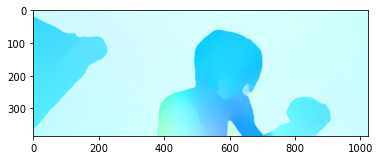

In [1]:
import cvbase as cvb
import numpy as np
import matplotlib.pyplot as plt
# to visualize a flow file
# cvb.show_flow('output.flo')
from cvbase.image import rgb2bgr
from cvbase.visualize import show_img
from cvbase.optflow.io import read_flow

def flow2rgb(flow, color_wheel=None, unknown_thr=1e6):
    """Convert flow map to RGB image
    Args:
        flow(ndarray): optical flow
        color_wheel(ndarray or None): color wheel used to map flow field to RGB
            colorspace. Default color wheel will be used if not specified
        unknown_thr(str): values above this threshold will be marked as unknown
            and thus ignored
    
    Returns:
        ndarray: an RGB image that can be visualized
    """
    assert flow.ndim == 3 and flow.shape[-1] == 2
    if color_wheel is None:
        color_wheel = make_color_wheel()
    assert color_wheel.ndim == 2 and color_wheel.shape[1] == 3
    num_bins = color_wheel.shape[0]

    dx = flow[:, :, 0].copy()
    dy = flow[:, :, 1].copy()

    ignore_inds = (np.isnan(dx) | np.isnan(dy) | (np.abs(dx) > unknown_thr) |
                   (np.abs(dy) > unknown_thr))
    dx[ignore_inds] = 0
    dy[ignore_inds] = 0

    rad = np.sqrt(dx**2 + dy**2)
    if np.any(rad > np.finfo(float).eps):
        max_rad = np.max(rad)
        dx /= max_rad
        dy /= max_rad

    [h, w] = dx.shape

    rad = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(-dy, -dx) / np.pi

    bin_real = (angle + 1) / 2 * (num_bins - 1)
    bin_left = np.floor(bin_real).astype(int)
    bin_right = (bin_left + 1) % num_bins
    w = (bin_real - bin_left.astype(np.float32))[..., None]
    flow_img = (
        1 - w) * color_wheel[bin_left, :] + w * color_wheel[bin_right, :]
    small_ind = rad <= 1
    flow_img[small_ind] = 1 - rad[small_ind, None] * (1 - flow_img[small_ind])
    flow_img[np.logical_not(small_ind)] *= 0.75

    flow_img[ignore_inds, :] = 0

    return flow_img

def make_color_wheel(bins=None):
    """Build a color wheel
    Args:
        bins(list or tuple, optional): specify number of bins for each color
            range, corresponding to six ranges: red -> yellow, yellow -> green,
            green -> cyan, cyan -> blue, blue -> magenta, magenta -> red.
            [15, 6, 4, 11, 13, 6] is used for default (see Middlebury).
    
    Returns:
        ndarray: color wheel of shape (total_bins, 3)
    """
    if bins is None:
        bins = [15, 6, 4, 11, 13, 6]
    assert len(bins) == 6

    RY, YG, GC, CB, BM, MR = tuple(bins)

    ry = [1, np.arange(RY) / RY, 0]
    yg = [1 - np.arange(YG) / YG, 1, 0]
    gc = [0, 1, np.arange(GC) / GC]
    cb = [0, 1 - np.arange(CB) / CB, 1]
    bm = [np.arange(BM) / BM, 0, 1]
    mr = [1, 0, 1 - np.arange(MR) / MR]

    num_bins = RY + YG + GC + CB + BM + MR

    color_wheel = np.zeros((3, num_bins), dtype=np.float32)

    col = 0
    for i, color in enumerate([ry, yg, gc, cb, bm, mr]):
        for j in range(3):
            color_wheel[j, col:col + bins[i]] = color[j]
        col += bins[i]

    return color_wheel.T

flow = read_flow('output.flo')
flow_img = flow2rgb(flow)
print(flow_img.shape)
plt.imsave('flow.png', flow_img)
plt.imshow(flow_img)
plt.show()